# Gradient Descent

How do we find the optimal weights for our learning models? Minimize the cost function. But how do we find the minimum? Gradient descent.

In [1]:
# load in our libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

#### But first our data

location: `/src/data/apes.csv`

Our data for today is just a few gorillas and what we have measure is each height and weight. 

In [2]:
data = "../data/apes.csv"
gorillas = pd.read_csv(data, index_col="id")
gorillas.head()

,weight,height
id,,
1,181,160
2,162,144
3,182,155
4,143,140
5,155,148


What our task is is to build a model that predicts a gorilla's height from their weight. Therefore, our `x` is weight and our `y` is height.

Text(0, 0.5, 'height(cm)')

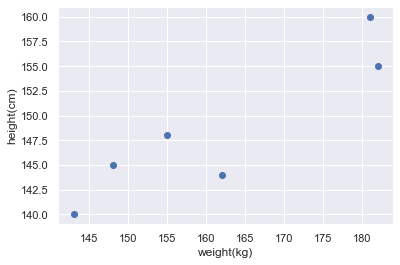

In [3]:
X = gorillas['weight'].values.reshape(-1,1)
y = gorillas['height'].values

plt.scatter(X, y)
plt.xlabel('weight(kg)')
plt.ylabel('height(cm)')

## Finding the model parameters with linear regression

Let's use least squares to find the optimal parameters (slope and intercept) for the simple linear regression model. 

When we run this following bit of code, we get the following equation for our model.

In [4]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X,y)
model.intercept_
model.coef_
print("y = {:.4f}x + {:.4f}".format(model.coef_[0], model.intercept_))

y = 0.4117x + 82.0468


Text(0, 0.5, 'height(cm)')

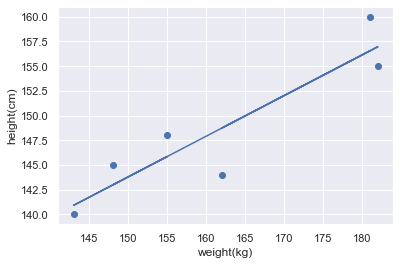

In [5]:
# X = weight
# y = height
plt.scatter(X, y)
plt.plot(X, model.predict(X))
plt.xlabel('weight(kg)')
plt.ylabel('height(cm)')


But let's play around with this to get a better intuition at how we derive these optimal values. To do so, we will only attempt to learn the optimal intercept. We'll rely on our model to have given us the optimal slope and will from here on forward hold this parameter constant at 0.4117.

What if we develop our own model where attempt to find the best intercept. How would we go about doing that? 

In [6]:
## first create a linear model that takes in the gorilla's weight,
## a slope (which we will always pass th value 0.4117 to
## and an intercept which we can change to see if we can minimize the loss function
def our_model(weight, slope, intercept):
    height = slope * weight + intercept
    return height

## let's test it out
weight = 150
slope = model.coef_[0]
our_intercept = 80

our_model(weight, slope, our_intercept)

141.7485672478966

Now let's run this model over our entire dataset for each gorilla's weight to predict each gorilla's height given our *randomly* assigned intercept.  We'll use these values to see what our new function looks like...

Text(0, 0.5, 'height(cm)')

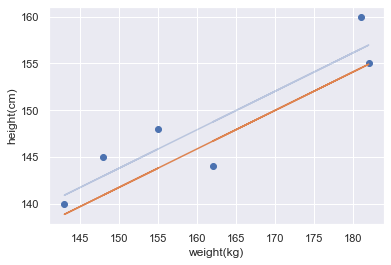

In [7]:
our_predictions = our_model(gorillas['weight'], slope, our_intercept)
our_predictions

plt.scatter(X, y)
plt.plot(X, model.predict(X), alpha=0.3)
plt.plot(X, our_predictions.values.reshape(-1,1))
plt.xlabel('weight(kg)')
plt.ylabel('height(cm)')

Let's us now calculate the residual sum of squares (rss/sse) as our loss. 

In [8]:
residuals = y - our_predictions
squared_residuals = residuals**2
sse = np.sum(squared_residuals)
print("sse: ", sse)

sse:  72.84451670258112


And now let's plot that loss (72.845) against the intercept (80) that resulted in that loss.

Text(0, 0.5, 'loss (sse)')

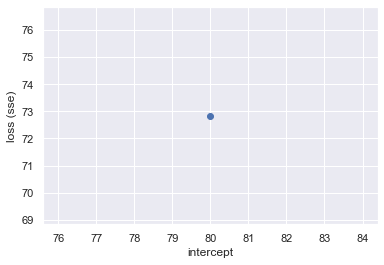

In [9]:
plt.scatter(our_intercept, sse)
plt.xlabel('intercept')
plt.ylabel('loss (sse)')

Now, let's pull this code into a function so that we can give ourself a simple way to calculate the loss given our observed weights (inputs), our observed heights (target) and any intercept. Essentially, since we want a way to minimize this loss, it is nice to wrap this logic in a function.

In [10]:
slope = model.coef_[0] # a refresher that our slope came from our linear regressor
def calculate_loss(x, y, intercept):
    predictions = our_model(x, slope, intercept)
    residuals = y - predictions
    squared_residuals = residuals**2
    sse = np.sum(squared_residuals)
    return sse

Now we just need to play around to see how this function works. Let's go ahead and try to intercepts and see how that affects the loss.

In [11]:
old_intercept = 80
new_intercept = 81
old_loss = calculate_loss(gorillas['weight'], gorillas['height'], old_intercept)
new_loss = calculate_loss(gorillas['weight'], gorillas['height'], new_intercept)

print("old intercept {} and old loss {}".format(old_intercept, old_loss))
print("new intercept {} and new loss {}".format(new_intercept, new_loss))

old intercept 80 and old loss 72.84451670258112
new intercept 81 and new loss 54.282634005349145


## Finding the mimimum loss

First thing that would be good to do is to remind ourself of the equation for our model so we can actually see what the optimal intercept is.

The next thing that I want to do is brute force the process of finding the optimal intercept. Essentially, slowly increase the intercept to descend down the loss function toward some minimum until we find the lowest point. Let's plot what I am saying...

y = 0.4117x + 82.0468


Text(0, 0.5, 'loss (sse)')

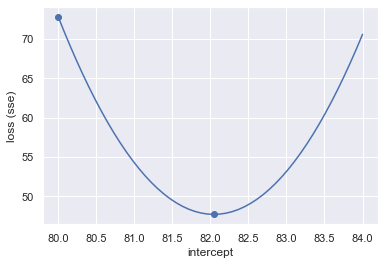

In [12]:
print("y = {:.4f}x + {:.4f}".format(model.coef_[0], model.intercept_))

brute_intercepts = np.linspace(80, 84)
losses = np.array([calculate_loss(gorillas['weight'], gorillas['height'], interc) for interc in brute_intercepts])

# grab the first guess intercept and the known optimal
sample_intercepts = np.array([80, model.intercept_])
sample_losses = np.array([calculate_loss(gorillas['weight'], gorillas['height'], interc) for interc in sample_intercepts])


plt.plot(brute_intercepts, losses)
plt.scatter(sample_intercepts, sample_losses) 
plt.xlabel('intercept')
plt.ylabel('loss (sse)')

But this is expensive!!! Remember, we are only trying to learn one parameter at the momemnt. Some our models in the future might have hundreds!!! Let's calculate the direction in which we should move down this function. In other words, we want to find the derivative of the loss function with respect to the intercept. 

In other words, this is the reate of change with respect to any given intercept that we choose... in other other words the slope of the function at that point.

$ {residual} = ({observed_{height}} - {predicted_{height}})^2 $

$ {predicted_{height}} = {0.4117}{weight} + {intercept} $

$ {residual} = ({observed_{height}} - {0.4117}{weight} + {intercept})^2 $

$ sse = \sum{residual_i}$

So we have to take the derivative of the Sum of Squared Errors with respect to the intercept which is just the sum of the derivatives with respect to the intercept of each square error.

Let's demonstrate!

In [13]:
# derivative allows us to calculate the numeric derivative
from scipy.misc import derivative

Let's take the first gorilla as an example and plug in those values to find our derivative given a particular intercept.

In [14]:
# numeric derivative
observed_height = gorillas['height'].loc[1]
weight = gorillas['weight'].loc[1]


def calculate_residual(intercept):
    return (observed_height - our_model(weight, slope, intercept))**2


derivative(calculate_residual, 82.0468)


-6.886524375076192

Now we need to sum these derivatives to find the derivative of the residual sum of squares function with respect to the intercept. The function below just finds all of the derivatives for each observed weight, observed height and a given intercept.

In [15]:
def find_derivatives(x, y, intercept, print_output):
    derivatives = []
    for i in range(gorillas.shape[0]):
        observed_height = gorillas['height'].loc[i + 1]
        weight = gorillas['weight'].loc[i + 1]
        
        def calculate_residual(intercept):
            return (observed_height - our_model(weight, slope, intercept))**2
        
        d = derivative(calculate_residual, intercept)
        if print_output: 
            print("observation: {} (observed height: {:.4f}; weight: {:.4f})".format(i + 1, observed_height, weight))
            print("equation: ({:.4f} - ({:.4f} X {:.4f} + intercept))^2".format(observed_height, slope, weight))
            print("derivative: {}\n".format(d))
        derivatives.append(d)
        
    return np.array(derivatives)

And now let's try it out for our intercept 80.

In [16]:
ds = find_derivatives(gorillas['weight'], gorillas['height'], 80, True)
print('individual residual function derivs: ', ds)
print('resid sum square function deriv: ', sum(ds))

observation: 1 (observed height: 160.0000; weight: 181.0000)
equation: (160.0000 - (0.4117 X 181.0000 + intercept))^2
derivative: -10.98012437507623

observation: 2 (observed height: 144.0000; weight: 162.0000)
equation: (144.0000 - (0.4117 X 162.0000 + intercept))^2
derivative: 5.376905255456677

observation: 3 (observed height: 155.0000; weight: 182.0000)
equation: (155.0000 - (0.4117 X 182.0000 + intercept))^2
derivative: -0.1568101451042594

observation: 4 (observed height: 140.0000; weight: 143.0000)
equation: (140.0000 - (0.4117 X 143.0000 + intercept))^2
derivative: -2.2660651140104733

observation: 5 (observed height: 148.0000; weight: 155.0000)
equation: (148.0000 - (0.4117 X 155.0000 + intercept))^2
derivative: -8.386294354347001

observation: 6 (observed height: 145.0000; weight: 148.0000)
equation: (145.0000 - (0.4117 X 148.0000 + intercept))^2
derivative: -8.149493964150679

individual residual function derivs:  [-10.98012438   5.37690526  -0.15681015  -2.26606511  -8.3862

The neat thing is, we know we are at a minimum point when the derivative approaches 0. Here, we know our optimal intercept is around 82.0468. Let's see if the slope of the line is approaching flatness if we hand our newly created function this value (just to test our intuition).

In [17]:
ds = find_derivatives(gorillas['weight'], gorillas['height'], 82.0468, True)
print(ds)
print(sum(ds))

observation: 1 (observed height: 160.0000; weight: 181.0000)
equation: (160.0000 - (0.4117 X 181.0000 + intercept))^2
derivative: -6.886524375076192

observation: 2 (observed height: 144.0000; weight: 162.0000)
equation: (144.0000 - (0.4117 X 162.0000 + intercept))^2
derivative: 9.470505255456656

observation: 3 (observed height: 155.0000; weight: 182.0000)
equation: (155.0000 - (0.4117 X 182.0000 + intercept))^2
derivative: 3.9367898548957787

observation: 4 (observed height: 140.0000; weight: 143.0000)
equation: (140.0000 - (0.4117 X 143.0000 + intercept))^2
derivative: 1.8275348859895075

observation: 5 (observed height: 148.0000; weight: 155.0000)
equation: (148.0000 - (0.4117 X 155.0000 + intercept))^2
derivative: -4.29269435434702

observation: 6 (observed height: 145.0000; weight: 148.0000)
equation: (145.0000 - (0.4117 X 148.0000 + intercept))^2
derivative: -4.055893964150698

[-6.88652438  9.47050526  3.93678985  1.82753489 -4.29269435 -4.05589396]
-0.0002826972319684984


Perhaps, it is easier to plot this just to see what is happening here.

Text(0, 0.5, 'loss (sse)')

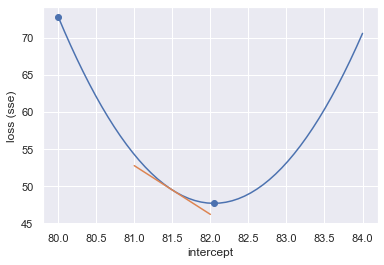

In [22]:
# just a helper function
def solve_for_b(slope,x, y):
    b = (slope * x - y)/-1
    return b

ix = 81.5 # we can change this value to see the slope at different intercepts along this function
iy = calculate_loss(gorillas['weight'], gorillas['height'], ix)
m = sum(find_derivatives(gorillas['weight'], gorillas['height'], ix, False))
b = solve_for_b(m, ix, iy)

def get_point(m, x, b):
    return m * x + b

tmp_x = np.array([ix-0.5, ix+0.5])
tmp_y = get_point(m, tmp_x, b)

tmp_y


plt.plot(brute_intercepts, losses)
plt.scatter(sample_intercepts, sample_losses) 
plt.plot(tmp_x, tmp_y)
plt.xlabel('intercept')
plt.ylabel('loss (sse)')

## Gradient Descent!!!
We can now use this value to tell us what direction and how big of a step to make and now we just need to take a step in that direction (opposite of the sign of the derivative). To specify the step size, we will just multiple the derivative by a learning rate (we have to decide this). The larger the learning rate the faster we learn but the higher the probability we miss the maximum.

The nice thing however, is as our derivative become smaller the smaller our steps become which means we make more adjustments toward the minimum that we do if our loss is higher.

In [19]:
start_intercept = 80
learning_rate = 0.1
direction = sum(find_derivatives(gorillas['weight'], gorillas['height'], start_intercept, False))
step_size = direction * learning_rate
print("step size ", step_size)

new_intercept = old_intercept - step_size
print("new intercept ", new_intercept)



step size  -2.4561882697231967
new intercept  82.4561882697232


And finally, let's find a better intercept by using gradient descent!!!

In [20]:
def gradient_descent(start_intercept, learning_rate):
    old_intercept = start_intercept
    
    for i in range(40):
        direction = sum(find_derivatives(gorillas['weight'], gorillas['height'], old_intercept, False))
        step_size = direction * learning_rate
        print("step size ", step_size)
        new_intercept = old_intercept - step_size
        loss = calculate_loss(gorillas['weight'], gorillas['height'], new_intercept)
        print("new intercept ", new_intercept)
        print("loss: ", loss, "\n")
        old_intercept = new_intercept

In [21]:
gradient_descent(80, 0.001)

step size  -0.024561882697231967
new intercept  80.02456188269723
loss:  72.24485033743846 

step size  -0.024267140104865293
new intercept  80.0488290228021
loss:  71.65948961310241 

step size  -0.02397593442360693
new intercept  80.0728049572257
loss:  71.08809325420627 

step size  -0.02368822321052363
new intercept  80.09649318043623
loss:  70.53032812684786 

step size  -0.023403964531997362
new intercept  80.11989714496822
loss:  69.98586904436782 

step size  -0.023123116957613377
new intercept  80.14302026192584
loss:  69.45439857775922 

step size  -0.02284563955412199
new intercept  80.16586590147996
loss:  68.9356068706022 

step size  -0.02257149187947249
new intercept  80.18843739335944
loss:  68.42919145841107 

step size  -0.022300633976918734
new intercept  80.21073802733636
loss:  67.93485709229304 

step size  -0.022033026369195737
new intercept  80.23277105370556
loss:  67.4523155668132 

step size  -0.02176863005276522
new intercept  80.25453968375832
loss:  66.981